In [3]:
import torch.nn as nn
import torch.nn.functional as F
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
import matplotlib.pyplot as plt
import torch.optim as optim
from tqdm import tqdm

from dataloader import CustomImageDataset
from torch.utils.data import DataLoader, random_split


In [17]:
# Define the transform
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # resize to 224x224
    transforms.ToTensor()
])

# Create the dataset and dataloader

class_to_idx = {'sma': 1, 'non-sma': 0}

# Get current directory
current_directory = os.getcwd()

# Relative directory of images
other_string = "Red_Cell_Morphology 4/"

# Combine directpries
new_path = os.path.join(current_directory, other_string)

# Create dataset
dataset = CustomImageDataset(root_dir=new_path, class_to_idx=class_to_idx, transform=transform)

# Define the train, validation, and test ratios (e.g., 70%, 15%, 15%)
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Calculate the number of samples for each split
num_samples = len(dataset)
train_samples = int(train_ratio * num_samples)
val_samples = int(val_ratio * num_samples)
test_samples = num_samples - train_samples - val_samples

# Use random_split to split the dataset
train_set, val_set, test_set = random_split(dataset, [train_samples, val_samples, test_samples])

# Create data loaders for each split
train_loader = DataLoader(train_set, batch_size=1, shuffle=True)
val_loader = DataLoader(val_set, batch_size=1, shuffle=False)  # No need to shuffle validation set
test_loader = DataLoader(test_set, batch_size=1, shuffle=False)  # No need to shuffle test set


In [18]:
# Get counts
counts = dataset.get_class_counts()
print(counts)

{'sma': 33, 'non-sma': 1}


Class: SMA, Number of images: 10


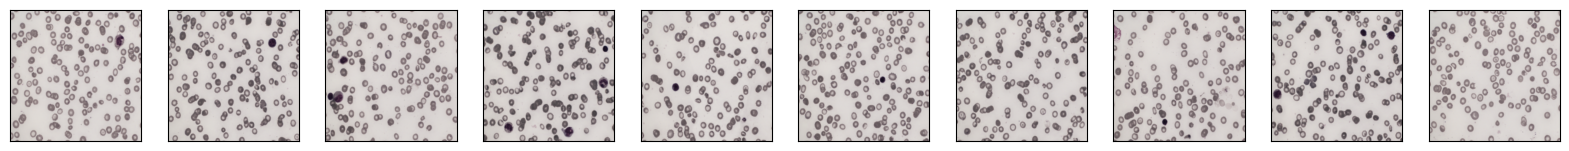

In [19]:
# Fetch first bag from the DataLoader
images, label = next(iter(train_loader))

print(f"Class: {'SMA' if label.item()==1 else 'non-SMA'}, Number of images: {len(images)}")

# Display all images from this bag
fig = plt.figure(figsize=(20, 10))  # adjust size as needed
for i in range(len(images)):
    ax = fig.add_subplot(1, len(images), i+1, xticks=[], yticks=[])
    img = images[i].squeeze().permute(1, 2, 0)  
    ax.imshow(img.numpy())
plt.show()

In [134]:
# Iterate through the data loader
for images, label in train_loader:
    # Iterate through each image in the bag
    for i in range(len(images[0])):
        print(f"Image {i+1} dimensions: {images[i].size()}")

Image 1 dimensions: torch.Size([1, 3, 224, 224])
Image 1 dimensions: torch.Size([1, 3, 224, 224])
Image 1 dimensions: torch.Size([1, 3, 224, 224])
Image 1 dimensions: torch.Size([1, 3, 224, 224])
Image 1 dimensions: torch.Size([1, 3, 224, 224])
Image 1 dimensions: torch.Size([1, 3, 224, 224])
Image 1 dimensions: torch.Size([1, 3, 224, 224])
Image 1 dimensions: torch.Size([1, 3, 224, 224])
Image 1 dimensions: torch.Size([1, 3, 224, 224])
Image 1 dimensions: torch.Size([1, 3, 224, 224])
Image 1 dimensions: torch.Size([1, 3, 224, 224])
Image 1 dimensions: torch.Size([1, 3, 224, 224])
Image 1 dimensions: torch.Size([1, 3, 224, 224])
Image 1 dimensions: torch.Size([1, 3, 224, 224])
Image 1 dimensions: torch.Size([1, 3, 224, 224])
Image 1 dimensions: torch.Size([1, 3, 224, 224])
Image 1 dimensions: torch.Size([1, 3, 224, 224])
Image 1 dimensions: torch.Size([1, 3, 224, 224])
Image 1 dimensions: torch.Size([1, 3, 224, 224])
Image 1 dimensions: torch.Size([1, 3, 224, 224])
Image 1 dimensions: 

KeyboardInterrupt: 

In [20]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 56 * 56, 500)  # Adjusted for input image size 224x224
        self.fc2 = nn.Linear(500, 100)
        self.fc3 = nn.Linear(100, 1)
        self.sigmoid = nn.Sigmoid()


    def forward(self, x):
        # Perform individual feature extraction on each image
        features = []
        for img in x:
            img_features = self.pool(F.relu(self.conv1(img)))
            img_features = self.pool(F.relu(self.conv2(img_features)))            
            img_features = img_features.view(img_features.size(0), -1)  # Flatten layer
            img_features = F.relu(self.fc1(img_features))
            img_features = self.fc2(img_features)
            features.append(img_features)

        # Apply max pooling across all images
        pooled_features = torch.stack(features)
        # print(pooled_features.size())
        pooled_features, _ = torch.max(pooled_features, dim=0)
        # print(pooled_features.size())

        # Flatten the pooled features
        x = pooled_features.view(pooled_features.size(0), -1)

        # Pass through the fully connected layers
        x = self.fc3(x)
        x = self.sigmoid(x)  # Apply sigmoid activation

        return x

In [21]:
# Initialize the network and optimizer
net = SimpleCNN()
loss = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(net.parameters(), lr=0.0001, momentum=0.9)

# Function to perform max pooling over feature vectors
def max_pool_feature_vectors(feature_vectors):
    return torch.max(feature_vectors, 0)[0]

# Calculate class frequencies
# class_0_count = 110  # Number of samples in class 0
# class_1_count = 33  # Number of samples in class 1

# # Calculate class weights
# total_count = class_0_count + class_1_count
# class_0_weight = total_count / (2 * class_0_count)
# class_1_weight = total_count / (2 * class_1_count)

# weight=torch.tensor([class_1_weight])
# print(weight)

# Initialize lists to store accuracy values
train_accuracy_list = []
val_accuracy_list = []
test_accuracy = 0.0       

# Training loop
for epoch in range(1):  # loop over the dataset multiple times

    running_loss = 0.0
    correct = 0
    total = 0

    with tqdm(total=len(train_loader),desc=f'Epoch {epoch+1}/{1}', unit='batch',) as pbar:
        for i, data in enumerate(train_loader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            # print(len(inputs))
            # print(inputs[0].size()) # Len n images of size [1,3,224,224]
            # print(labels) # Tensor scalar
            
            target = net(inputs)
            print('actual label: ', labels)

            print('target: ', target)
            # target = torch.round(target,1)
            objective = loss(target[0],labels.float())
            objective.backward()
            optimizer.step()
            

            # Update accuracy
            predicted = target.data.round().int()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # print statistics
            running_loss += objective.item()
            
             # Print loss in every minibatch
            print(f'Epoch {epoch+1}/{1}, Minibatch {i+1}/{len(train_loader)}, Loss: {objective.item()}')
            pbar.update(1)

    # Calculate training accuracy
    train_accuracy = 100 * correct / total
    train_accuracy_list.append(train_accuracy)

    # Validation accuracy
    net.eval()  # Switch to evaluation mode
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for data in val_loader:
            inputs, labels = data
            target = net(inputs)

            # Calculate validation accuracy
            predicted = target.data.round().int()
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_accuracy = 100 * val_correct / val_total
    val_accuracy_list.append(val_accuracy)

# Testing accuracy
net.eval()  # Switch to evaluation mode
test_correct = 0
test_total = 0

with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        target = net(inputs)

        # Calculate test accuracy
        predicted = target.data.round().int()
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_accuracy = 100 * test_correct / test_total

print(f'Training Accuracy: {train_accuracy_list[-1]:.2f}%')
print(f'Validation Accuracy: {val_accuracy_list[-1]:.2f}%')
print(f'Test Accuracy: {test_accuracy:.2f}%')

print('Finished Training')


Epoch 1/1:   0%|          | 0/23 [00:00<?, ?batch/s]

actual label:  tensor([1])
target:  tensor([[0.5057]], grad_fn=<SigmoidBackward0>)


Epoch 1/1:   4%|▍         | 1/23 [00:06<02:12,  6.00s/batch]

Epoch 1/1, Minibatch 1/23, Loss: 0.4719434678554535
actual label:  tensor([1])
target:  tensor([[0.5053]], grad_fn=<SigmoidBackward0>)


Epoch 1/1:   9%|▊         | 2/23 [00:14<02:34,  7.37s/batch]

Epoch 1/1, Minibatch 2/23, Loss: 0.47209417819976807
actual label:  tensor([1])
target:  tensor([[0.5077]], grad_fn=<SigmoidBackward0>)


Epoch 1/1:  13%|█▎        | 3/23 [00:21<02:22,  7.12s/batch]

Epoch 1/1, Minibatch 3/23, Loss: 0.47116026282310486
actual label:  tensor([1])
target:  tensor([[0.5100]], grad_fn=<SigmoidBackward0>)


Epoch 1/1:  17%|█▋        | 4/23 [00:24<01:47,  5.67s/batch]

Epoch 1/1, Minibatch 4/23, Loss: 0.47032538056373596
actual label:  tensor([1])
target:  tensor([[0.5126]], grad_fn=<SigmoidBackward0>)


Epoch 1/1:  22%|██▏       | 5/23 [00:32<01:54,  6.38s/batch]

Epoch 1/1, Minibatch 5/23, Loss: 0.469353586435318
actual label:  tensor([1])
target:  tensor([[0.5196]], grad_fn=<SigmoidBackward0>)


Epoch 1/1:  26%|██▌       | 6/23 [00:35<01:32,  5.41s/batch]

Epoch 1/1, Minibatch 6/23, Loss: 0.46673688292503357
actual label:  tensor([1])
target:  tensor([[0.5270]], grad_fn=<SigmoidBackward0>)


Epoch 1/1:  30%|███       | 7/23 [00:38<01:14,  4.66s/batch]

Epoch 1/1, Minibatch 7/23, Loss: 0.46395421028137207
actual label:  tensor([1])
target:  tensor([[0.5350]], grad_fn=<SigmoidBackward0>)


Epoch 1/1:  35%|███▍      | 8/23 [00:48<01:32,  6.16s/batch]

Epoch 1/1, Minibatch 8/23, Loss: 0.4610128104686737
actual label:  tensor([1])
target:  tensor([[0.5436]], grad_fn=<SigmoidBackward0>)


Epoch 1/1:  39%|███▉      | 9/23 [00:54<01:26,  6.20s/batch]

Epoch 1/1, Minibatch 9/23, Loss: 0.4578283727169037
actual label:  tensor([1])
target:  tensor([[0.5528]], grad_fn=<SigmoidBackward0>)


Epoch 1/1:  43%|████▎     | 10/23 [01:01<01:25,  6.55s/batch]

Epoch 1/1, Minibatch 10/23, Loss: 0.45447349548339844
actual label:  tensor([1])
target:  tensor([[0.5686]], grad_fn=<SigmoidBackward0>)


Epoch 1/1:  48%|████▊     | 11/23 [01:10<01:25,  7.13s/batch]

Epoch 1/1, Minibatch 11/23, Loss: 0.44872233271598816
actual label:  tensor([1])
target:  tensor([[0.5758]], grad_fn=<SigmoidBackward0>)


Epoch 1/1:  52%|█████▏    | 12/23 [01:14<01:09,  6.30s/batch]

Epoch 1/1, Minibatch 12/23, Loss: 0.4461124539375305
actual label:  tensor([1])
target:  tensor([[0.5874]], grad_fn=<SigmoidBackward0>)


Epoch 1/1:  57%|█████▋    | 13/23 [01:19<00:59,  5.98s/batch]

Epoch 1/1, Minibatch 13/23, Loss: 0.44196563959121704
actual label:  tensor([1])
target:  tensor([[0.6050]], grad_fn=<SigmoidBackward0>)


Epoch 1/1:  61%|██████    | 14/23 [01:24<00:49,  5.52s/batch]

Epoch 1/1, Minibatch 14/23, Loss: 0.4357156753540039
actual label:  tensor([1])
target:  tensor([[0.6227]], grad_fn=<SigmoidBackward0>)


Epoch 1/1:  65%|██████▌   | 15/23 [01:31<00:47,  5.98s/batch]

Epoch 1/1, Minibatch 15/23, Loss: 0.42951175570487976
actual label:  tensor([1])
target:  tensor([[0.6326]], grad_fn=<SigmoidBackward0>)


Epoch 1/1:  70%|██████▉   | 16/23 [01:39<00:45,  6.51s/batch]

Epoch 1/1, Minibatch 16/23, Loss: 0.42606320977211
actual label:  tensor([1])
target:  tensor([[0.6614]], grad_fn=<SigmoidBackward0>)


Epoch 1/1:  74%|███████▍  | 17/23 [01:43<00:35,  5.90s/batch]

Epoch 1/1, Minibatch 17/23, Loss: 0.4161679446697235
actual label:  tensor([1])
target:  tensor([[0.6771]], grad_fn=<SigmoidBackward0>)


Epoch 1/1:  78%|███████▊  | 18/23 [01:48<00:28,  5.66s/batch]

Epoch 1/1, Minibatch 18/23, Loss: 0.4108458459377289
actual label:  tensor([1])
target:  tensor([[0.6977]], grad_fn=<SigmoidBackward0>)


Epoch 1/1:  83%|████████▎ | 19/23 [01:54<00:22,  5.61s/batch]

Epoch 1/1, Minibatch 19/23, Loss: 0.40396106243133545
actual label:  tensor([0])
target:  tensor([[0.7311]], grad_fn=<SigmoidBackward0>)


Epoch 1/1:  87%|████████▋ | 20/23 [01:55<00:13,  4.38s/batch]

Epoch 1/1, Minibatch 20/23, Loss: 1.1240818500518799
actual label:  tensor([1])
target:  tensor([[0.7493]], grad_fn=<SigmoidBackward0>)


Epoch 1/1:  91%|█████████▏| 21/23 [01:58<00:07,  3.97s/batch]

Epoch 1/1, Minibatch 21/23, Loss: 0.38711145520210266
actual label:  tensor([1])
target:  tensor([[0.7624]], grad_fn=<SigmoidBackward0>)


Epoch 1/1:  96%|█████████▌| 22/23 [02:00<00:03,  3.30s/batch]

Epoch 1/1, Minibatch 22/23, Loss: 0.3829251229763031
actual label:  tensor([1])
target:  tensor([[0.7984]], grad_fn=<SigmoidBackward0>)


Epoch 1/1: 100%|██████████| 23/23 [02:02<00:00,  5.33s/batch]

Epoch 1/1, Minibatch 23/23, Loss: 0.3715953230857849


Training Accuracy: 4.35%
Validation Accuracy: 0.00%
Test Accuracy: 0.00%
Finished Training


In [32]:
test_total=0
test_correct=0
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        target = net(inputs)
        print('target', target)
        print('labels: ', labels)

        # Calculate test accuracy
        print('target data:' , target.data)
        predicted = target.data.round().int()
        print('predicted', predicted)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_accuracy = 100 * test_correct / test_total
print(test_accuracy)

target tensor([[0.8240]])
labels:  tensor([1])
target data: tensor([[0.8240]])
predicted tensor([[1]], dtype=torch.int32)
target tensor([[0.8167]])
labels:  tensor([1])
target data: tensor([[0.8167]])
predicted tensor([[1]], dtype=torch.int32)
target tensor([[0.8113]])
labels:  tensor([1])
target data: tensor([[0.8113]])
predicted tensor([[1]], dtype=torch.int32)
target tensor([[0.8184]])
labels:  tensor([1])
target data: tensor([[0.8184]])
predicted tensor([[1]], dtype=torch.int32)
target tensor([[0.8050]])
labels:  tensor([1])
target data: tensor([[0.8050]])
predicted tensor([[1]], dtype=torch.int32)
target tensor([[0.8205]])
labels:  tensor([1])
target data: tensor([[0.8205]])
predicted tensor([[1]], dtype=torch.int32)
100.0
